In [4]:
# Importaciones básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import pickle
import os
import tqdm as notebook_tqdm
from tqdm import tqdm
import torch

# Importaciones de darts
from darts import TimeSeries
from darts.metrics import mae, mape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

#Importar el StandardScaler() para normalizar los datos de un pandas dataframe
from sklearn.preprocessing import StandardScaler

# Métricas de scikit-learn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Para optimización de hiperparámetros
import optuna

# TimesFM y sus dependencias
from chronos import ChronosPipeline



# Configuración de logging
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

In [5]:
# Cargar datos
df = pd.read_csv('monthly_data.csv')
df['DATES'] = pd.to_datetime(df['DATES'])
df.set_index('DATES', inplace=True)

df = df.dropna()
df.head(), df.tail()

(              PEN
 DATES            
 1994-12-31  2.185
 1995-01-31  2.194
 1995-02-28  2.237
 1995-03-31  2.258
 1995-04-30  2.245,
                PEN
 DATES             
 2024-04-30  3.7664
 2024-05-31  3.7245
 2024-06-30  3.8425
 2024-07-31  3.7283
 2024-08-31  3.7493)

In [6]:
# Preprocesamiento de datos son pandas
series = df[['PEN']]
train_size = int(len(series) * 0.8)
train_data, test_data = series[:train_size], series[train_size:]

# Funciones Auxiliares

In [7]:
# Funciones auxiliares que necesitaremos
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

def save_hyperparameters(params, model_name):
    filename = f'best_hyperparameters_{model_name}.json'
    with open(filename, 'w') as f:
        json.dump(params, f)
    print(f"Hiperparámetros guardados en {filename}")
    
def load_hyperparameters(model_name):
    filename = f'best_hyperparameters_{model_name}.json'
    try:
        with open(filename, 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        return None

def save_model(model, model_name):
    filename = f'{model_name}_model.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Modelo guardado en {filename}")

def load_model(model_name):
    filename = f'{model_name}_model.pkl'
    try:
        with open(filename, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        return None

# Funciones para la estrategia de trading

# Transform the serie en returns
def return_series(series):
    if not isinstance(series, pd.Series):
        raise TypeError("La serie debe ser un objeto de tipo pandas.Series para calcular los retornos.")
    return series.pct_change().dropna()

def implement_trading_strategy(real_returns, predicted_returns):
    if isinstance(real_returns, np.ndarray):
        real_returns_pd = pd.Series(real_returns)
    elif isinstance(real_returns, pd.Series):
        real_returns_pd = real_returns
    else:
        raise ValueError("real_returns must be either numpy array or pandas Series.")

    if isinstance(predicted_returns, np.ndarray):
        predicted_returns_pd = pd.Series(predicted_returns)
    elif isinstance(predicted_returns, pd.Series):
        predicted_returns_pd = predicted_returns
    else:
        raise ValueError("predicted_returns must be either numpy array or pandas Series.")

    # Create the position and calculate strategy returns
    position = pd.Series(np.where(predicted_returns_pd > 0, 1, -1), index=predicted_returns_pd.index)
    strategy_returns = real_returns_pd * position.shift(1)
    
    return strategy_returns

def calculate_cumulative_return(returns):
    return (1 + returns).cumprod() - 1

def calculate_performance_metrics(pred_returns, benchmark_returns=None):
    # Asegurar que los inputs sean pandas.Series
    if not isinstance(pred_returns, pd.Series):
        pred_returns = pd.Series(pred_returns)
    
    # Crear un benchmark de ceros si no se proporciona uno
    if benchmark_returns is None:
        benchmark_returns = pd.Series([0] * len(pred_returns), index=pred_returns.index)
    elif not isinstance(benchmark_returns, pd.Series):
        benchmark_returns = pd.Series(benchmark_returns)
    
    # Retornos totales y anualizados
    total_return = (1 + pred_returns).prod() - 1
    annualized_return = (1 + total_return) ** (12 / len(pred_returns)) - 1

    # Sharpe Ratio (sin tasa libre de riesgo)
    sharpe_ratio = np.sqrt(12) * pred_returns.mean() / pred_returns.std()

    # Exceso de retornos para Information Ratio
    excess_returns = pred_returns - benchmark_returns
    tracking_error = excess_returns.std()
    information_ratio = excess_returns.mean() / tracking_error

    # Máximo Drawdown
    cumulative_returns = (1 + pred_returns).cumprod()
    peak = cumulative_returns.cummax()
    max_drawdown = ((cumulative_returns / peak) - 1).min()

    return {
        "Total Return": total_return,
        "Annualized Return": annualized_return,
        "Sharpe Ratio": sharpe_ratio,
        "Information Ratio": information_ratio,
        "Max Drawdown": max_drawdown
    }

def calculate_hit_ratio(y_pred, y_true=None):
    """
    Calcula el Hit Ratio entre los valores reales y predichos.
    
    :param y_true: Array o Series con los valores reales, usa y_pred como y_true si no se proporciona
    :param y_pred: Array o Series con los valores predichos
    :return: Tupla con (hit_ratio, hit_ratio_string)
    
    Si y_true no se proporciona, se calculará el hit ratio de y_pred contra sí mismo.
    """
    if y_true is None:
        y_true = y_pred
    if isinstance(y_true, pd.Series):
        y_true = y_true.to_numpy()
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.to_numpy()

    if len(y_pred) != len(y_true):
        raise ValueError("y_pred and y_true must have the same length.")

    same_sign_count = np.sum(np.sign(y_pred) == np.sign(y_true))
    hit_ratio = same_sign_count / len(y_true) * 100

    hit_ratio_string = f'Hit Ratio = {hit_ratio:.2f}%'
    
    return hit_ratio, hit_ratio_string

# Función para calcular todas las métricas incluyendo Hit Ratio
def calculate_all_metrics(pred_returns,real_returns=None):
    performance_metrics = calculate_performance_metrics(pred_returns,real_returns)
    hit_ratio, hit_ratio_string = calculate_hit_ratio(pred_returns,real_returns)
    
    all_metrics = {
        **performance_metrics,
        "Hit Ratio": hit_ratio,

    }
    
    return all_metrics

def evaluate_model_performance(y_true, y_pred, model_name, retrain=False):
    # Handle Darts TimeSeries objects
    if isinstance(y_true, TimeSeries):
        y_true = y_true.values()  # Convert to NumPy array
    if isinstance(y_pred, TimeSeries):
        y_pred = y_pred.values()  # Convert to NumPy array

    # Ensure y_true and y_pred are numpy arrays or pandas Series
    if not isinstance(y_true, (np.ndarray, pd.Series)):
        raise TypeError(f"y_true debe ser un numpy.ndarray, pandas.Series o Darts TimeSeries, pero se recibió {type(y_true)}")
    if not isinstance(y_pred, (np.ndarray, pd.Series)):
        raise TypeError(f"y_pred debe ser un numpy.ndarray, pandas.Series o Darts TimeSeries, pero se recibió {type(y_pred)}")

    # Convert to numpy array if it's a pandas Series
    y_true_np = y_true.values if isinstance(y_true, pd.Series) else y_true
    y_pred_np = y_pred.values if isinstance(y_pred, pd.Series) else y_pred

    # Error metrics calculation
    mse = mean_squared_error(y_true_np, y_pred_np)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    r2 = r2_score(y_true_np, y_pred_np)

    error_metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

    # Convert to pandas Series for return calculations
    y_true_series = pd.Series(y_true.flatten()) if isinstance(y_true, np.ndarray) else y_true
    y_pred_series = pd.Series(y_pred.flatten()) if isinstance(y_pred, np.ndarray) else y_pred

    # Ensure they are Series before calculating returns
    try:
        y_true_returns = return_series(y_true_series)
        y_pred_returns = return_series(y_pred_series)
    except TypeError as e:
        print(f"Error: {e}")
        return None, None

    # Implement trading strategy
    strategy_returns = implement_trading_strategy(y_true_returns, y_pred_returns)

    # Calculate performance metrics
    performance_metrics = calculate_performance_metrics(strategy_returns, y_true_returns)

    # Calculate Hit Ratio
    hit_ratio, hit_ratio_string = calculate_hit_ratio(strategy_returns, y_true_returns)

    # Combine all metrics
    all_metrics = {
        "Model": model_name,
        "Retrain": retrain,
        **error_metrics,
        **performance_metrics,
        "Hit Ratio": hit_ratio
    }

    return all_metrics, strategy_returns

# MODELO Chronos

In [9]:
pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-base",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)

In [10]:
def optimize_chronos(train_data,checkpoint):
    def objective(trial):
        # Definir los hiperparámetros que vamos a optimizar
        params = {
            'prediction_length': 1,  # Fijo en 1 para predicción paso a paso
            'num_samples': trial.suggest_int('num_samples', 50, 200),
            'temperature': trial.suggest_float('temperature', 0.1, 1.0),
            'top_k': trial.suggest_int('top_k', 10, 100),
            'top_p': trial.suggest_float('top_p', 0.1, 1.0)
        }

        try:
            # Inicializar el pipeline
            pipeline = checkpoint

            # Preparar datos para validación
            val_size = int(len(train_data) * 0.2)
            train_subset = train_data[:-val_size]
            val_subset = train_data[-val_size:]

            # Realizar predicciones en el conjunto de validación
            errors = []
            for i in range(len(val_subset) - 1):
                context = train_subset.append(val_subset[:i])
                context_tensor = torch.tensor(context.values().flatten())
                
                forecast = pipeline.predict(
                    context=context_tensor,
                    **params
                )
                
                # Calcular error para esta predicción
                actual = val_subset[i:i+1].values().flatten()
                pred = np.median(forecast.numpy(), axis=1)
                error = np.abs(actual - pred).mean()
                errors.append(error)

            return np.mean(errors)

        except Exception as e:
            print(f"Error en optimización: {str(e)}")
            return float('inf')

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=20)
    
    best_params = study.best_params
    best_params['prediction_length'] = 1
    
    return best_params

In [11]:
def train_chronos(train_data,checkpoint):
    loaded_params = load_hyperparameters('chronos')
    if loaded_params is None:
        print("Optimizando hiperparámetros para Chronos...")
        best_params = optimize_chronos(train_data,checkpoint=checkpoint)
        save_hyperparameters(best_params, 'chronos')
    else:
        print("Cargando hiperparámetros guardados para Chronos...")
        best_params = loaded_params
    
    pipeline = checkpoint
    
    return pipeline, best_params

In [17]:
def chronos_step_by_step_forecast(model, train_data, test_data, retrain=False, progress_bar=None):
    """
    Realiza predicciones paso a paso usando el modelo Chronos con parámetros optimizados
    """
    # Cargar parámetros optimizados
    try:
        with open('best_hyperparameters_chronos.json', 'r') as f:
            best_params = json.load(f)
            print("Usando parámetros optimizados:", best_params)
    except FileNotFoundError:
        print("No se encontraron parámetros optimizados, usando valores por defecto del modelo")
        best_params = {
            'num_samples': 20,
            'temperature': 1.0,
            'top_k': 50,
            'top_p': 1.0,
            'prediction_length': 1
        }
    
    forecast_filename = f'chronos_forecast_{"retrain" if retrain else "no_retrain"}.pkl'
    
    if os.path.exists(forecast_filename):
        print(f"Cargando forecast guardado de {forecast_filename}")
        with open(forecast_filename, 'rb') as f:
            return pickle.load(f)
    
    predictions = []
    current_train = train_data.pd_dataframe()
    
    for i in tqdm(range(len(test_data)), desc="Generating predictions"):
        # Preparar el contexto
        context_tensor = torch.tensor(current_train.values.flatten(), dtype=torch.float32)
        
        try:
            # Realizar predicción usando los parámetros optimizados
            forecast = model.predict(
                context=context_tensor,
                prediction_length=1,  # Siempre 1 para predicción paso a paso
                num_samples=best_params['num_samples'],
                temperature=best_params['temperature'],
                top_k=best_params['top_k'],
                top_p=best_params['top_p']
            )
            
            # Tomar la mediana de las muestras como predicción
            pred = np.median(forecast.numpy(), axis=1)
            predictions.append(pred)
            
        except Exception as e:
            print(f"Error en la predicción paso {i}: {str(e)}")
            if len(predictions) > 0:
                predictions.append(predictions[-1])
            else:
                predictions.append(current_train.values[-1])
        
        # Actualizar serie de entrenamiento con valor real
        new_point = test_data[i:i+1].pd_dataframe()
        current_train = pd.concat([current_train, new_point])
        
        if progress_bar:
            progress_bar.update(100 // len(test_data))
    
    # Crear TimeSeries con las predicciones
    predictions = np.array(predictions).flatten()
    forecast = TimeSeries.from_times_and_values(
        times=test_data.time_index,
        values=predictions.reshape(-1, 1)
    )
    
    # Guardar predicciones
    print(f"Guardando forecast en {forecast_filename}")
    with open(forecast_filename, 'wb') as f:
        pickle.dump(forecast, f)
    
    return forecast

In [13]:


# Preprocesamiento de datos
series = TimeSeries.from_dataframe(df[['PEN']])
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [14]:
# Entrenar modelo Chronos
chronos_model, best_params = train_chronos(train_scaled,pipeline)

[I 2024-11-13 20:19:45,050] A new study created in memory with name: no-name-d755a641-0b36-4103-accd-d422a9aa87d9


Optimizando hiperparámetros para Chronos...


[I 2024-11-13 20:19:54,551] Trial 0 finished with value: 0.022402988468391376 and parameters: {'num_samples': 59, 'temperature': 0.21733629740907706, 'top_k': 20, 'top_p': 0.7918127059857754}. Best is trial 0 with value: 0.022402988468391376.
[I 2024-11-13 20:23:44,503] Trial 1 finished with value: 0.022426979783704025 and parameters: {'num_samples': 155, 'temperature': 0.672341766397725, 'top_k': 32, 'top_p': 0.9582017920425624}. Best is trial 0 with value: 0.022402988468391376.
[I 2024-11-13 20:27:36,335] Trial 2 finished with value: 0.02217403255461123 and parameters: {'num_samples': 154, 'temperature': 0.679293064429296, 'top_k': 28, 'top_p': 0.4394326016687048}. Best is trial 2 with value: 0.02217403255461123.
[I 2024-11-13 20:44:57,955] Trial 3 finished with value: 0.022479527828138196 and parameters: {'num_samples': 189, 'temperature': 0.2976840977317705, 'top_k': 75, 'top_p': 0.4266548139254298}. Best is trial 2 with value: 0.02217403255461123.
[I 2024-11-13 20:45:13,416] Trial

Hiperparámetros guardados en best_hyperparameters_chronos.json


In [16]:
# 2. Ejecutar la inspección detallada
def inspect_chronos_pipeline(pipeline):
    """
    Inspección detallada del pipeline de Chronos y sus componentes
    """
    print("=== INSPECCIÓN DEL PIPELINE DE CHRONOS ===\n")
    
    # 1. Estructura básica
    print("1. Estructura básica:")
    print(f"Tipo de pipeline: {type(pipeline)}")
    if hasattr(pipeline, 'tokenizer'):
        print(f"Tipo de tokenizer: {type(pipeline.tokenizer)}")
    if hasattr(pipeline, 'model'):
        print(f"Tipo de modelo: {type(pipeline.model)}")
    print()
    
    # 2. Inspección del tokenizer
    print("2. Configuración del Tokenizer:")
    if hasattr(pipeline, 'tokenizer'):
        tokenizer = pipeline.tokenizer
        if hasattr(tokenizer, 'config'):
            config = tokenizer.config
            print("Parámetros del tokenizer:")
            try:
                for key, value in vars(config).items():
                    print(f"  - {key}: {value}")
            except:
                print("  No se pueden obtener los parámetros del tokenizer directamente")
                print("  Configuración:", config)
    print()
    
    # 3. Inspección del modelo
    print("3. Configuración del Modelo:")
    if hasattr(pipeline, 'model'):
        model = pipeline.model
        print("Atributos del modelo:")
        for attr in dir(model):
            if not attr.startswith('_'):  # Solo atributos públicos
                try:
                    value = getattr(model, attr)
                    if not callable(value):  # Ignorar métodos
                        print(f"  - {attr}: {value}")
                except:
                    print(f"  - {attr}: <no se puede acceder>")
    print()
    
    # 4. Inspección del modelo interno
    print("4. Modelo Interno:")
    if hasattr(pipeline.model, 'model'):
        inner_model = pipeline.model.model
        print(f"Tipo de modelo interno: {type(inner_model)}")
        if hasattr(inner_model, 'config'):
            print("\nConfiguración del modelo interno:")
            config = inner_model.config
            try:
                chronos_config = config.chronos_config
                print("\nChronos Config:")
                for key, value in chronos_config.items():
                    print(f"  - {key}: {value}")
            except:
                print("No se puede acceder a chronos_config")
    print()

print("\nInspeccionando el modelo...")
inspect_chronos_pipeline(chronos_model)

# 3. Hacer una predicción de prueba
print("\n=== PRUEBA DE PREDICCIÓN ===")
test_tensor = torch.tensor([1.0, 2.0, 3.0], dtype=torch.float32)
try:
    with torch.no_grad():
        prediction = chronos_model.predict(
            context=test_tensor,
            prediction_length=1
        )
        print("Predicción exitosa!")
        print("Forma de la predicción:", prediction.shape)
except Exception as e:
    print(f"Error en predicción de prueba: {e}")


Inspeccionando el modelo...
=== INSPECCIÓN DEL PIPELINE DE CHRONOS ===

1. Estructura básica:
Tipo de pipeline: <class 'chronos.chronos.ChronosPipeline'>
Tipo de tokenizer: <class 'chronos.chronos.MeanScaleUniformBins'>
Tipo de modelo: <class 'chronos.chronos.ChronosModel'>

2. Configuración del Tokenizer:
Parámetros del tokenizer:
  - tokenizer_class: MeanScaleUniformBins
  - tokenizer_kwargs: {'low_limit': -15.0, 'high_limit': 15.0}
  - context_length: 512
  - prediction_length: 64
  - n_tokens: 4096
  - n_special_tokens: 2
  - pad_token_id: 0
  - eos_token_id: 1
  - use_eos_token: True
  - model_type: seq2seq
  - num_samples: 20
  - temperature: 1.0
  - top_k: 50
  - top_p: 1.0

3. Configuración del Modelo:
Atributos del modelo:
  - T_destination: ~T_destination
  - call_super_init: False
  - config: ChronosConfig(tokenizer_class='MeanScaleUniformBins', tokenizer_kwargs={'low_limit': -15.0, 'high_limit': 15.0}, context_length=512, prediction_length=64, n_tokens=4096, n_special_toke

In [18]:
# Realizar rolling forecast
chronos_forecast_no_retrain = chronos_step_by_step_forecast(
    chronos_model, train_scaled, test_scaled, retrain=False)

chronos_forecast_with_retrain = chronos_step_by_step_forecast(
    chronos_model, train_scaled, test_scaled, retrain=True)
    


Usando parámetros optimizados: {'num_samples': 154, 'temperature': 0.679293064429296, 'top_k': 28, 'top_p': 0.4394326016687048, 'prediction_length': 1}


Generating predictions: 100%|██████████| 72/72 [34:28<00:00, 28.73s/it]


Guardando forecast en chronos_forecast_no_retrain.pkl
Usando parámetros optimizados: {'num_samples': 154, 'temperature': 0.679293064429296, 'top_k': 28, 'top_p': 0.4394326016687048, 'prediction_length': 1}


Generating predictions: 100%|██████████| 72/72 [59:24<00:00, 49.51s/it]  

Guardando forecast en chronos_forecast_retrain.pkl


In [19]:
# Desescalar las predicciones
chronos_forecast_no_retrain_unscaled = scaler.inverse_transform(chronos_forecast_no_retrain)
chronos_forecast_with_retrain_unscaled = scaler.inverse_transform(chronos_forecast_with_retrain)

In [20]:
# Evaluar ambos modelos
y_true = test.values().flatten()
y_pred_no_retrain = chronos_forecast_no_retrain_unscaled.values().flatten()
y_pred_with_retrain = chronos_forecast_with_retrain_unscaled.values().flatten()

chronos_evaluation_no_retrain = evaluate_model(y_true, y_pred_no_retrain)
chronos_evaluation_with_retrain = evaluate_model(y_true, y_pred_with_retrain)

print("Evaluación del modelo Chronos sin reentrenamiento:")
for metric, value in chronos_evaluation_no_retrain.items():
    print(f"{metric}: {value:.6f}")

print("\nEvaluación del modelo Chronos con reentrenamiento:")
for metric, value in chronos_evaluation_with_retrain.items():
    print(f"{metric}: {value:.6f}")
    


Evaluación del modelo Chronos sin reentrenamiento:
MSE: 0.005684
RMSE: 0.075393
MAE: 0.059996
R2: 0.891850

Evaluación del modelo Chronos con reentrenamiento:
MSE: 0.005742
RMSE: 0.075773
MAE: 0.060386
R2: 0.890757


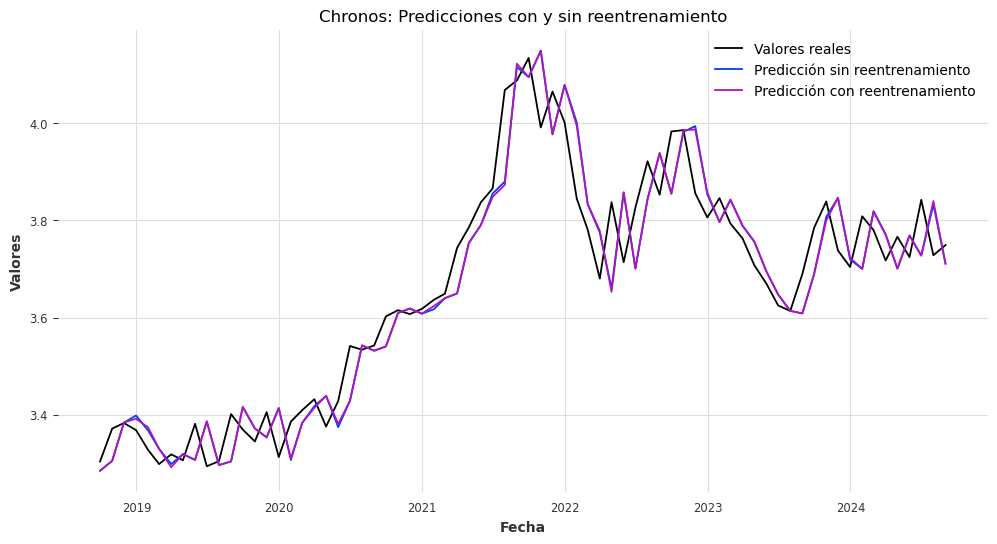

In [21]:
# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(test.time_index, y_true, label='Valores reales')
plt.plot(test.time_index, y_pred_no_retrain, label='Predicción sin reentrenamiento')
plt.plot(test.time_index, y_pred_with_retrain, label='Predicción con reentrenamiento')
plt.legend()
plt.title('Chronos: Predicciones con y sin reentrenamiento')
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.show()

In [22]:
# Implementar estrategia de trading
real_returns = return_series(test.pd_series())
pred_returns_no_retrain = return_series(chronos_forecast_no_retrain_unscaled.pd_series())
pred_returns_with_retrain = return_series(chronos_forecast_with_retrain_unscaled.pd_series())

In [23]:
# Implementar estrategia de trading para ambos casos
strategy_returns_no_retrain = implement_trading_strategy(real_returns, pred_returns_no_retrain)
strategy_returns_with_retrain = implement_trading_strategy(real_returns, pred_returns_with_retrain)

In [24]:
# Calcular retornos acumulados
cumulative_real = calculate_cumulative_return(real_returns)
cumulative_strategy_no_retrain = calculate_cumulative_return(strategy_returns_no_retrain)
cumulative_strategy_with_retrain = calculate_cumulative_return(strategy_returns_with_retrain)

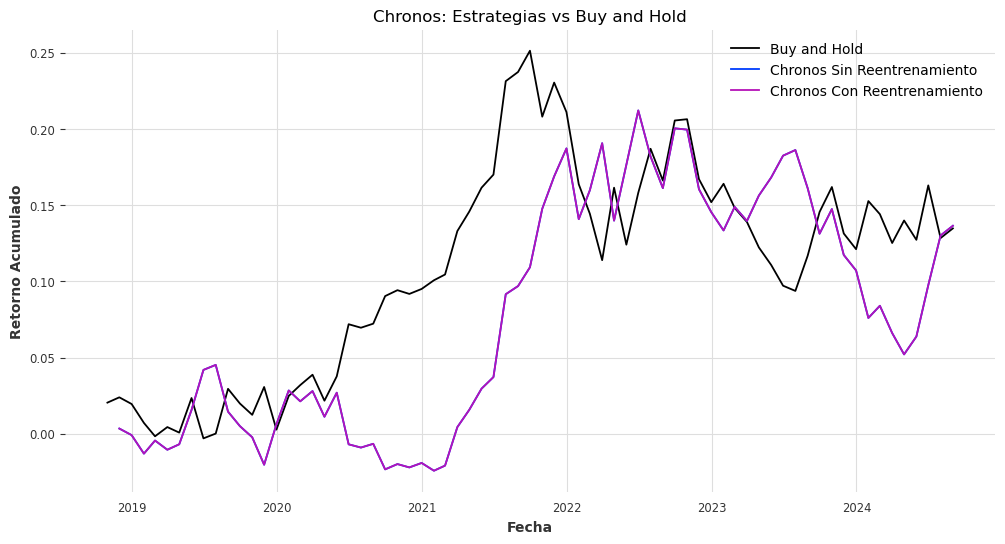

In [25]:
# Visualizar resultados de la estrategia
plt.figure(figsize=(12, 6))
plt.plot(cumulative_real.index, cumulative_real, label='Buy and Hold')
plt.plot(cumulative_strategy_no_retrain.index, cumulative_strategy_no_retrain, 
         label='Chronos Sin Reentrenamiento')
plt.plot(cumulative_strategy_with_retrain.index, cumulative_strategy_with_retrain, 
         label='Chronos Con Reentrenamiento')
plt.legend()
plt.title('Chronos: Estrategias vs Buy and Hold')
plt.xlabel('Fecha')
plt.ylabel('Retorno Acumulado')
plt.show()

In [26]:
# Calcular métricas de rendimiento
metrics_buy_hold = calculate_all_metrics(real_returns)
metrics_strategy_no_retrain = calculate_all_metrics(strategy_returns_no_retrain, real_returns)
metrics_strategy_with_retrain = calculate_all_metrics(strategy_returns_with_retrain, real_returns)

print("\nMétricas de rendimiento:")
print("\nBuy and Hold:")
for k, v in metrics_buy_hold.items():
    print(f"{k}: {v:.4f}")
print("\nEstrategia Chronos sin reentrenamiento:")
for k, v in metrics_strategy_no_retrain.items():
    print(f"{k}: {v:.4f}")
print("\nEstrategia Chronos con reentrenamiento:")
for k, v in metrics_strategy_with_retrain.items():
    print(f"{k}: {v:.4f}")


Métricas de rendimiento:

Buy and Hold:
Total Return: 0.1348
Annualized Return: 0.0216
Sharpe Ratio: 0.3437
Information Ratio: 0.0992
Max Drawdown: -0.1260
Hit Ratio: 100.0000

Estrategia Chronos sin reentrenamiento:
Total Return: 0.1365
Annualized Return: 0.0219
Sharpe Ratio: 0.3521
Information Ratio: 0.0109
Max Drawdown: -0.1321
Hit Ratio: 53.5211

Estrategia Chronos con reentrenamiento:
Total Return: 0.1365
Annualized Return: 0.0219
Sharpe Ratio: 0.3521
Information Ratio: 0.0109
Max Drawdown: -0.1321
Hit Ratio: 53.5211


In [27]:
# Guardar métricas finales para comparación de modelos
chronos_metrics_no_retrain, chronos_returns_no_retrain = evaluate_model_performance(
    y_true, y_pred_no_retrain, "CHRONOS", retrain=False)
chronos_metrics_with_retrain, chronos_returns_with_retrain = evaluate_model_performance(
    y_true, y_pred_with_retrain, "CHRONOS", retrain=True)